In [2]:
from typing import TypedDict,Annotated,Optional
from langgraph.graph import StateGraph,END,add_messages
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.tools import TavilySearchResults
from langgraph.checkpoint.memory import MemorySaver
from dotenv import load_dotenv

load_dotenv()

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-001")

In [3]:
search_tools = TavilySearchResults(max_result = 4)

tools = [search_tools]

memory = MemorySaver()

In [4]:
llm_with_tools = llm.bind_tools(tools=tools)

In [5]:
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage

In [6]:
class State(TypedDict):
  messages: Annotated[list,add_messages]

In [7]:
async def model(state: State):
  result = await llm_with_tools.ainvoke(state["messages"])
  return {
    "messages":[result]
  }

In [8]:
async def tools_router(state: State):
  last_message = state['messages'][-1]

  if hasattr(last_message,"tool_calls") and len(last_message.tool_calls) > 0:
    return "tool_node"
  else:
    return END

In [9]:
async def tool_node(state:State):
  """Custom tool node that handle tool calls from LLM """
  tool_calls = state['messages'][-1].tool_calls

  tool_messages = []

  for tool_call in tool_calls:
    tool_name = tool_call["name"]
    tool_id = tool_call["id"]
    tool_args = tool_call["args"]

    if tool_name == "tavily_search_results_json":
      search_result = await search_tools.ainvoke(tool_args)

      tool_message = ToolMessage(
        content=str(search_result),
          tool_call_id=tool_id,
          name=tool_name
      )

      tool_messages.append(tool_message)
  return {"messages":tool_messages}

In [10]:
graph_builder = StateGraph(State)
graph_builder.add_node("model",model)
graph_builder.add_node("tool_node",tool_node)
graph_builder.set_entry_point("model")

graph_builder.add_conditional_edges("model",tools_router,{
  END:END,
  "tool_node":"tool_node"
})
graph_builder.add_edge("tool_node","model")

graph = graph_builder.compile(checkpointer=memory)

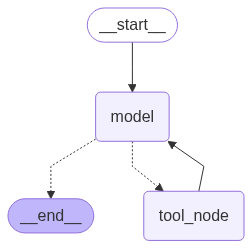

In [11]:
from IPython.display import Image,display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
  Image(
    graph.get_graph().draw_mermaid_png(
      draw_method=MermaidDrawMethod.API
    )
  )
)

In [21]:
config = {
    "configurable": {
        "thread_id": 4
    }
}

In [ ]:
response = await graph.ainvoke({
    "messages": [HumanMessage(content="Who win the ipl 2025?")], 
}, config=config)

In [28]:
input = {
    "messages": ["Hi, how are you?"]
}

events = graph.astream_events(input=input, version="v2")

async for event in events: 
    print(event)

{'event': 'on_chain_start', 'data': {'input': {'messages': ['Hi, how are you?']}}, 'name': 'LangGraph', 'tags': [], 'run_id': '4b93e6c1-594f-4da9-8162-6e6d88f37135', 'metadata': {}, 'parent_ids': []}


ValueError: Checkpointer requires one or more of the following 'configurable' keys: ['thread_id', 'checkpoint_ns', 'checkpoint_id']